In [1]:
import os
import sys
with open('/home/yy503/Desktop/emi_line_eor/path_info.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)
        dir_name,path = line.split()
        locals()[dir_name] = path # assign path to dir variable 
        sys.path.append(path) # append the path

from multiprocessing import Pool

from tkinter import font
import jphot as jp
import lya_utils as lya
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import stats
import NewHaloMakerRoutines as hmr
import movie_utils
import astropy.units as u; import astropy.constants as c

from sim import anal_ramses_sim_util as anal_sim_util 
import astro_util
import coord_util
import plot_util as pu
from const_util import *
import rascas_util
from plot import comp_plot
import math_util
from astro import obs_util

from scipy.ndimage import gaussian_filter
import healpy
#from healpy.newvisufunc import projview, newprojplot
import selected_snapshots

import imp

import yt
import random

sim_suite_dir /data/ERCblackholes2/smartin/Dwarf1

prj_dir /home/yy503/Desktop/emi_line_eor

prj_dir_EBH /data/ERCblackholes3/yuxuan/lya_pandora

prj_dir_Peta4 /rds/project/dirac_vol2/rds-dirac-dp012/yy503/lya_project

prj_dir_cosma /cosma/home/dp012/dc-yuan3/lya_pandora

util_dir /home/yy503/Desktop/num_util

rascas_dir /home/yy503/Desktop/simulation_code/rascas-develop

rascas_new_ions_dir /home/yy503/Desktop/simulation_code/rascas-new_ions

rascas_dir_Peta4 /home/yy503/rascas-develop

rascas_dir_cosma /cosma/home/dp012/dc-yuan3/rascas-develop

rascas_py_dir /home/yy503/Desktop/simulation_code/rascas-develop/py

sunset_dir /home/yy503/Desktop/simulation_code/sunset

Hlmkr_dir /home/yy503/Desktop/simulation_code/ramses_tools/HaloMakerRoutines/

MkMv_dir  /home/yy503/Desktop/simulation_code/ramses_tools/MakeMovies


In [2]:
%matplotlib inline

## RASCAS py routine and intrinsic routine

In [3]:
imp.reload(rascas_util)

sim_name='RTCRiMHD+SfFb'
op_idx=66
op_idx2 = anal_sim_util.op_idx_int2str(op_idx)
lfac, dfac, tfac, aexp, ctime, redshift, redshiftnum = anal_sim_util.get_sim_info(sim_suite_dir, sim_name, op_idx, halo_method=None)
ppic_method='twoshell'



In [4]:

emi_dir = '%s/Lya/%s/output%s/intrinsic'%(prj_dir_EBH, sim_name, op_idx2)

size, ndir, LOS_a, lam, v, lam_star, intr_flux_a2, intr_spectrum_a2, intr_image_a2, intr_cube_a2, \
intr_spectrum_a, intr_image_a, intr_ppv_a, intr_flux, fesc_lya_aavg, fesc_lya_a, \
intr_spectrum_aavg, spectrum_aavg, noise_flux_a, noise_spectrum_a, noise_image_a, noise_cube_a = \
rascas_util.read_Lya(emi_dir, redshiftnum, lfac, ppic_method=ppic_method, more_op=True)

dl=lam[1]-lam[0]
intr_image_a *= (1+redshiftnum)**4
intr_image_a2 *=(1+redshiftnum)**4
intr_spectrum_a *= (1+redshiftnum)**4
intr_spectrum_a2 *= (1+redshiftnum)**4


read_Lya
read_rascas_output: reading col_ism
read_rascas_output: reading col_cgm
read_rascas_output: reading rec_ism
read_rascas_output: reading rec_cgm


## Calculate from gas

In [5]:
halo_method={'halo_pos':[0.521649,0.473574,0.484625], 'halo_vel': [0,0,0]}
amr_dat_a = anal_sim_util.read_gas_data(prj_dir_EBH+'/Lya', sim_suite_dir, sim_name, op_idx, halo_method=halo_method, method='yt')

x = amr_dat_a['x']
y = amr_dat_a['y']
z = amr_dat_a['z']

vx = amr_dat_a['vx']
vy = amr_dat_a['vy']
vz = amr_dat_a['vz']
v_vec = np.stack( (vx, vy, vz) ).transpose()

ngas = len(x)

cell_vol = amr_dat_a['cell_vol']
dens   = amr_dat_a['dens']
p_th   = amr_dat_a['p_th']
xHII   = amr_dat_a['xHII']
xHeII  = amr_dat_a['xHeII']
xHeIII = amr_dat_a['xHeIII']


ndens, nH, nHI, nHII, nHe, nHeI, nHeII, nHeIII, ne = \
  astro_util.cal_ion_number_density(dens, [xHII, xHeII, xHeIII] )
TK = astro_util.cal_TK(p_th, ndens)

prob_case_B, alpha_B, Lya_rec = rascas_util.cal_Lya_rec(TK, ne, nHII)
collExrate_HI, Lya_col = rascas_util.cal_Lya_col(TK, nHI, ne, coeff='Goerdt10')

Lya_lum = Lya_rec*cell_vol+Lya_col*cell_vol

yt : [INFO     ] 2024-09-08 18:19:43,835 Parameters: current_time              = 2.5462473022176098
yt : [INFO     ] 2024-09-08 18:19:43,835 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-09-08 18:19:43,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-08 18:19:43,836 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-08 18:19:43,836 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-09-08 18:19:43,836 Parameters: current_redshift          = 3.4943621695652674
yt : [INFO     ] 2024-09-08 18:19:43,837 Parameters: omega_lambda              = 0.693499982357025
yt : [INFO     ] 2024-09-08 18:19:43,837 Parameters: omega_matter              = 0.306499987840652
yt : [INFO     ] 2024-09-08 18:19:43,837 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-09-08 18:19:43,837 Parameters: hubble_constant           = 0.6790000152587891
yt : [WARNING  ] 2024-09-08 18:19:45,686 This output ha

## Intrinsic image

In [6]:
lid = 0
LOS = LOS_a[lid]

image_npix = 200
size=10*u.kpc

imp.reload(obs_util)
img = obs_util.cal_intr_img_gas(x,y,z, Lya_lum, LOS, image_npix, size, redshiftnum)
img = img*(1+redshiftnum)**4

cal_LOS_frame: k_perp1, [0, 1, 0] k_perp2 [0, 0, 1]


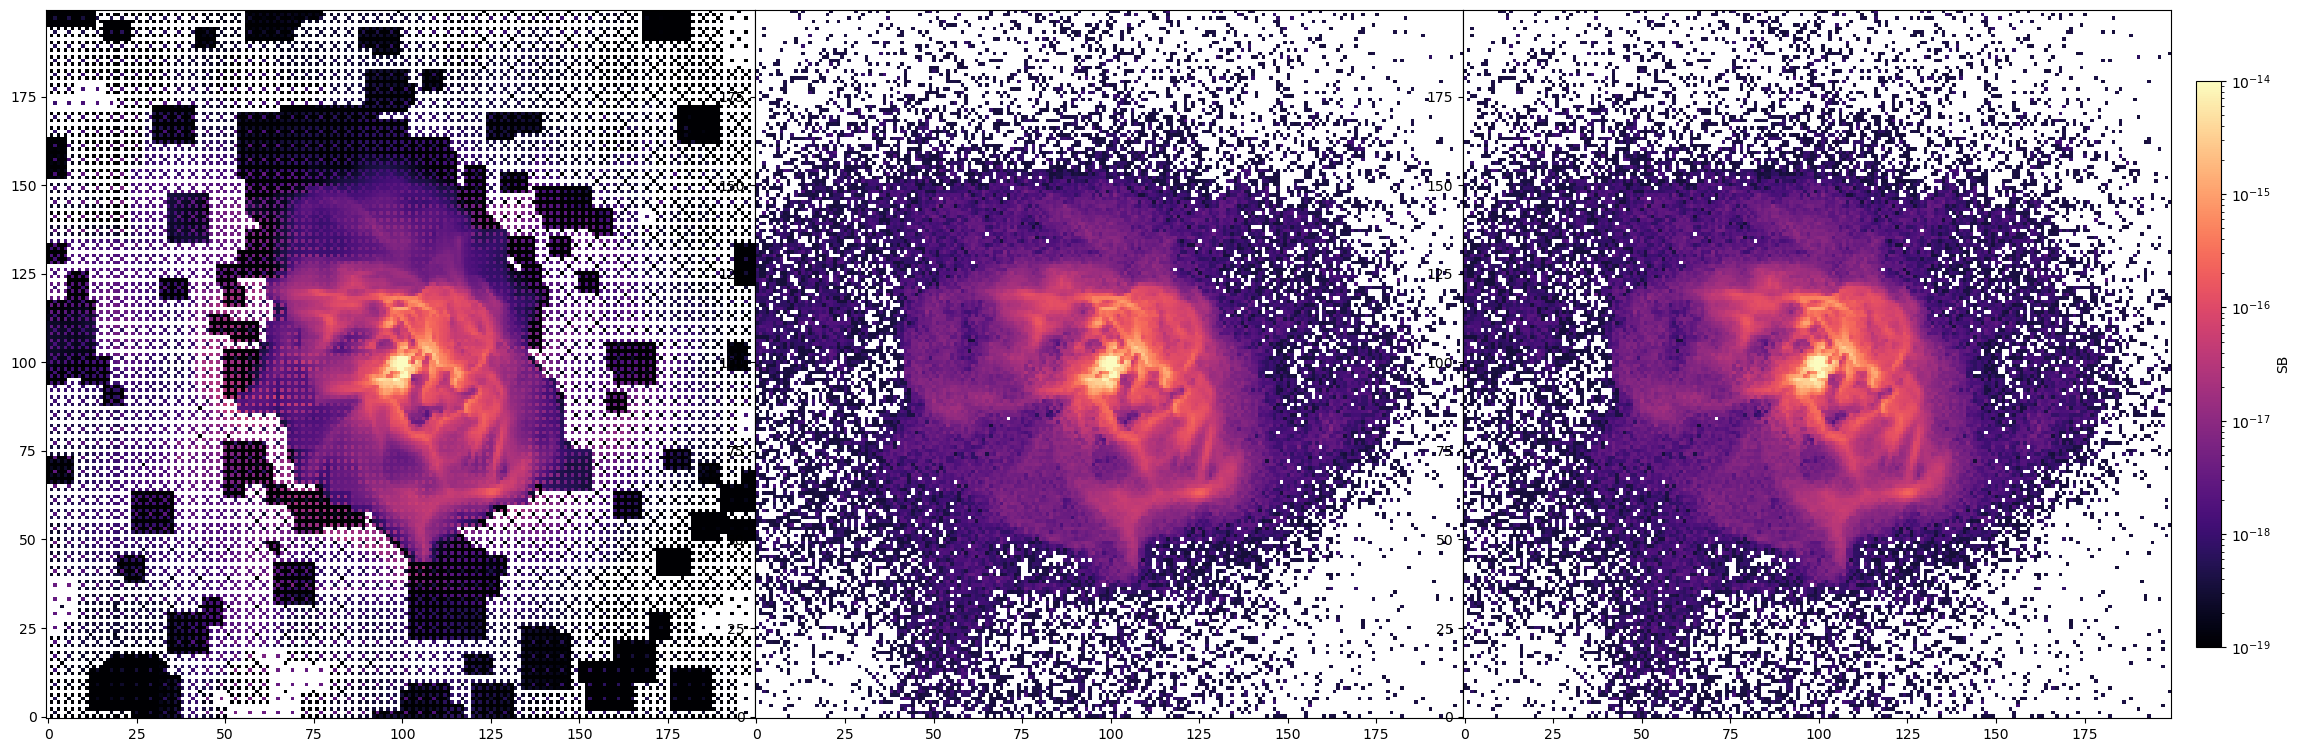

In [7]:
nrow=1
ncol=3
bottom=0.1
top=0.99
left=0.06
right=0.91

wspace=0.
hspace=0.

cb_frac=0.8
cb_par = {'pad': 0.01, 'wcb': 0.01}
cb_bedge, lcb = pu.colorbar_edges(nrow, bottom, top, cb_frac, hspace)
fig_width, fig_height = pu.calculate_fig_size(nrow, ncol, wspace, hspace, (bottom, top, left, right), panel_ratio=1, mode='publication')

fig, axs = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height), sharex=False, sharey=False, gridspec_kw = {'wspace':wspace, 'hspace':hspace, 'bottom': bottom, 'top': top, 'left': left, 'right':right})

norm = LogNorm(vmin=1e-19, vmax=1e-14)
cmap = 'magma'
axs[0].imshow(img.value, norm=norm, origin='lower', cmap=cmap )

axs[1].imshow(intr_image_a[lid], norm=norm, origin='lower', cmap=cmap )

axs[2].imshow(intr_image_a2[0], norm=norm, origin='lower', cmap=cmap )

# set colorbar
for i in range(nrow):
    label = 'SB'
    cbar_ax = fig.add_axes([ right+cb_par['pad'], cb_bedge[i], cb_par['wcb'], lcb])
    cbar = fig.colorbar( mpl.cm.ScalarMappable(norm=norm, cmap=cmap ), cax=cbar_ax )
    cbar.set_label( label )

## Intrinsic spectra

In [8]:
lid = 0
LOS = LOS_a[lid]
m_HI = c.m_p+c.m_e
nu_lya = c.c/(lam_lya*u.Angstrom)

sig = astro_util.cal_Dopwidth(nu_lya, m_HI, TK )
nu_a = astro_util.v2nu(v, nu_lya)
    


intr_spec = obs_util.cal_intr_spec_gas(v_vec, sig, Lya_lum, LOS, nu_a, nu_lya, size, redshiftnum)
intr_spec *= (1+redshiftnum)**4

Angstrom Hz erg / cm


(-200.0, 200.0)

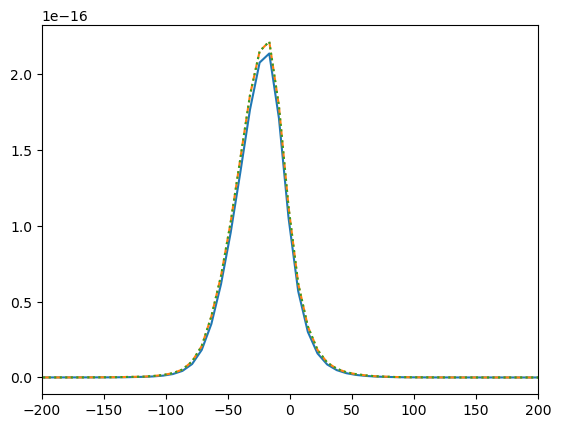

In [9]:
plt.plot(v, intr_spec)
plt.plot(v, intr_spectrum_a[lid], ls='--' )
plt.plot(v, intr_spectrum_a2[0], ls=':' )

plt.xlim(-200, 200)